# Traffic Simulation in Berlin

This notebook simulates traffic flow on a road network in Berlin using OSMnx and NetworkX libraries.
It demonstrates how to create a agent-based model for traffic simulation on real-world road data.

In [95]:
# Install required packages
#!pip install osmnx ipywidgets

In [96]:
# Import necessary libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
import re # Added for robust speed parsing

## Road Network Management

First, we'll define a class to manage and visualize the road network.

In [97]:
class RoadNetwork:
    """Class to manage and visualize road networks from OpenStreetMap."""
    
    def __init__(self, address="Adalbertstraße 58, Berlin, Germany", dist=1000, network_type="drive", 
                 default_speed_kmh=30, min_speed_kmh=5): # Added speed parameters
        """Initialize the road network from a given address.
        
        Args:
            address (str): Address to center the network around
            dist (int): Distance in meters to define network radius
            network_type (str): Type of network (drive, bike, walk, etc.)
            default_speed_kmh (int): Default speed in km/h if parsing fails
            min_speed_kmh (int): Minimum speed in km/h to assume for calculations
        """
        print(f"Fetching road network for {address}...")
        self.G = ox.graph_from_address(address, dist=dist, network_type=network_type)
        print("Network fetched. Adding travel times...")
        # Pass speed parameters to _add_travel_time
        self._add_travel_time(default_speed_kmh=default_speed_kmh, min_speed_kmh=min_speed_kmh)
        print("Travel times added. Inspecting weights...")
        self._inspect_travel_times()
        print("Weight inspection complete. RoadNetwork initialized.")
        
    def _add_travel_time(self, default_speed_kmh, min_speed_kmh): # Accept speed parameters
        """Add travel time attribute (in minutes) to each edge based on speed limit and length.
           Handles various speed formats and ensures positive travel time.
        """
        # Removed hardcoded defaults, now uses parameters
        for u, v, k, data in self.G.edges(data=True, keys=True):
            speed_str = data.get("maxspeed", str(default_speed_kmh))
            speed_kmh = default_speed_kmh # Start with default
            length_m = data.get("length", 0)

            if isinstance(speed_str, list): # Handle list of speeds
                found_speed = False
                for item in speed_str:
                    if isinstance(item, str):
                        match = re.search(r'^\d+', item)
                        if match:
                            speed_str = item
                            found_speed = True
                            break
                    elif isinstance(item, (int, float)):
                        speed_str = item
                        found_speed = True
                        break
                if not found_speed:
                    speed_str = str(default_speed_kmh) 

            if isinstance(speed_str, str):
                match = re.search(r'^\d+(\.\d+)?', speed_str.lower())
                if match:
                    try:
                        speed_val = float(match.group(0))
                        if "mph" in speed_str.lower():
                            speed_kmh = speed_val * 1.60934 
                        else:
                            speed_kmh = speed_val 
                    except ValueError:
                        speed_kmh = default_speed_kmh 
                else:
                    speed_kmh = default_speed_kmh 
            elif isinstance(speed_str, (int, float)): 
                 speed_kmh = float(speed_str)
            else:
                 speed_kmh = default_speed_kmh 

            speed_kmh = max(speed_kmh, min_speed_kmh)

            if length_m > 0:
                 travel_time_minutes = length_m / (speed_kmh * 1000 / 60)
                 data["travel_time"] = max(travel_time_minutes, 1e-6)
            else:
                 data["travel_time"] = 1e-6
    
    def _inspect_travel_times(self):
        """Inspects a sample of edge travel times for validity."""
        invalid_count = 0
        checked_count = 0
        print("  Sample Edge Travel Times:")
        for u, v, k, data in self.G.edges(data=True, keys=True):
            if checked_count < 10:
                print(f"    Edge ({u}, {v}, {k}): travel_time = {data.get('travel_time')}")
            tt = data.get('travel_time', None)
            if tt is None or not isinstance(tt, (float, int)) or tt <= 0:
                invalid_count += 1
                if invalid_count <= 10:
                     print(f"    --> INVALID travel_time found: Edge=({u},{v},{k}), Value={tt}")
            checked_count += 1
        
        if invalid_count > 0:
            print(f"  WARNING: Found {invalid_count} edges with invalid travel_time (<= 0 or None/NaN) out of {checked_count} total edges.")
        else:
            print(f"  All {checked_count} edge travel times appear valid (> 0).")
    
    def plot(self, figsize=(10, 10)):
        """Plot the road network.
        
        Args:
            figsize (tuple): Size of the figure (width, height)
            
        Returns:
            tuple: Figure and axis objects
        """
        fig, ax = ox.plot_graph(self.G, figsize=figsize)
        return fig, ax
    
    def get_nodes(self):
        """Get all nodes in the network.
        
        Returns:
            list: List of node IDs
        """
        return list(self.G.nodes())

Fetching road network for Adalbertstraße 58, Berlin, Germany...
Network fetched. Adding travel times...
Travel times added. Inspecting weights...
  Sample Edge Travel Times:
    Edge (21487224, 196725581, 0): travel_time = 0.01537106963203514
    Edge (21487224, 29215073, 0): travel_time = 0.3689634104868936
    Edge (21487230, 26960762, 0): travel_time = 0.3340867491301488
    Edge (21487230, 28794539, 0): travel_time = 0.19171355203742896
    Edge (21487230, 196724115, 0): travel_time = 0.25157650175925506
    Edge (21487230, 1491865195, 0): travel_time = 0.2218420297795194
    Edge (21487231, 29215047, 0): travel_time = 0.24856366811134678
    Edge (21487231, 5984003368, 0): travel_time = 0.3617606020635326
    Edge (21487232, 29218315, 0): travel_time = 0.1802223881370233
    Edge (21487232, 269476782, 0): travel_time = 0.08445051356189222
  All 533 edge travel times appear valid (> 0).
Weight inspection complete. RoadNetwork initialized.


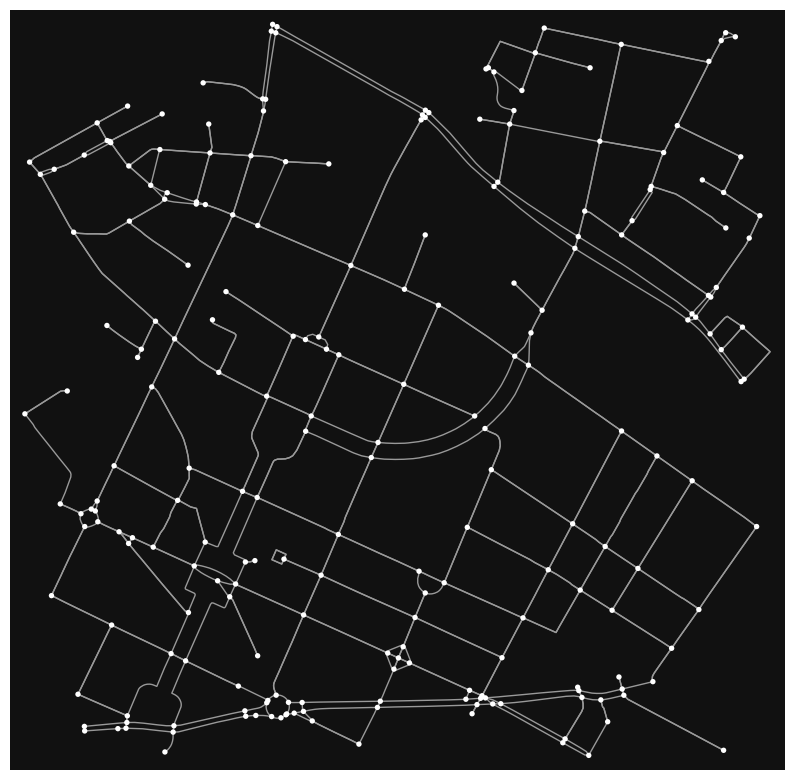

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [98]:
# Create a road network for Berlin with custom speed parameters
berlin_network = RoadNetwork(default_speed_kmh=5, min_speed_kmh=3)

# Plot the road network
berlin_network.plot()

## Traffic Simulation

Now we'll define classes for traffic simulation. This includes:

1. A Car class to represent vehicles moving through the network
2. A TrafficSimulator class to manage the simulation

In [103]:
class Car:
    """Class representing a car in the traffic simulation."""
    
    def __init__(self, start, destination):
        """Initialize a car with start and destination nodes.
        
        Args:
            start: Node ID where the car starts
            destination: Node ID where the car is heading
        """
        self.current_location = start
        self.destination = destination
        self.path = []  # Will be populated with nodes to traverse
        self.travel_time = 0  # Total time spent traveling
        self.reroute_count = 0  # Number of times the car has rerouted
        self.journeys_completed = 0  # Number of journeys completed
        self.last_moved = 0  # Timestamp when car last moved (to detect stuck cars)
        self.is_stuck = False  # Flag to indicate if the car is stuck
        
class TrafficSimulator:
    """Class to simulate traffic flow on a road network."""
    
    def __init__(self, road_network, num_cars=100, traffic_jam_threshold=5, reroute_probability=0.3):
        """Initialize the traffic simulator.
        
        Args:
            road_network (RoadNetwork): The road network to simulate on
            num_cars (int): Number of cars to simulate
            traffic_jam_threshold (int): Number of cars on an edge that constitutes a jam
            reroute_probability (float): Probability of a car rerouting when encountering a jam
        """
        self.road_network = road_network
        self.G = road_network.G
        self.traffic_jam_threshold = traffic_jam_threshold
        self.reroute_probability = reroute_probability
        
        # Precompute strongly connected components to ensure valid paths
        self.connected_components = list(nx.strongly_connected_components(self.G))
        self.largest_component = max(self.connected_components, key=len)
        
        # Create cars and initialize simulation metrics
        self.cars = self._create_cars(num_cars)
        self.step_count = 0
        self.traffic_data = []  # Store traffic data for analysis
        
    def _create_cars(self, num_cars):
        """Create cars with start and destination nodes in the same component.
        
        Args:
            num_cars (int): Number of cars to create
            
        Returns:
            list: List of Car objects
        """
        # Use nodes from the largest strongly connected component to ensure paths exist
        component_nodes = list(self.largest_component)
        
        if len(component_nodes) < 2:
            print("WARNING: Largest connected component has fewer than 2 nodes. Using all nodes instead.")
            component_nodes = self.road_network.get_nodes()
        
        print(f"Creating {num_cars} cars using {len(component_nodes)} nodes from largest connected component")
        
        cars_list = []
        retry_count = 0
        max_retries = num_cars * 10  # Limit retries to avoid infinite loop
        
        # Loop until we have the desired number of cars with different start/end points
        while len(cars_list) < num_cars and retry_count < max_retries:
            start_node = random.choice(component_nodes)
            dest_node = random.choice(component_nodes)
            
            # Ensure start and destination are different
            if start_node != dest_node:
                # Verify path exists before creating car
                try:
                    path = nx.shortest_path(self.G, start_node, dest_node, weight="travel_time")
                    if path and len(path) > 1:
                        car = Car(start_node, dest_node)
                        car.path = path[1:]  # Skip current location
                        cars_list.append(car)
                except (nx.NetworkXNoPath, nx.NetworkXError):
                    retry_count += 1
                    continue
            else:
                retry_count += 1
        
        if len(cars_list) < num_cars:
            print(f"WARNING: Could only create {len(cars_list)} cars with valid paths")
            
        return cars_list
    
    def _assign_new_destination(self, car):
        """Assigns a new random destination to the car, ensuring it's different from the current location
        and a path exists between them."""
        component_nodes = list(self.largest_component)
        retry_count = 0
        max_retries = 20
        
        while retry_count < max_retries:
            new_destination = random.choice(component_nodes)
            if new_destination != car.current_location:
                try:
                    path = nx.shortest_path(self.G, car.current_location, 
                                          new_destination, weight="travel_time")
                    if path and len(path) > 1:
                        car.destination = new_destination
                        car.path = path[1:]  # Skip current location
                        return True
                except (nx.NetworkXNoPath, nx.NetworkXError):
                    retry_count += 1
                    continue
            retry_count += 1
            
        # If we can't find a valid destination after max retries, leave it as is
        print(f"WARNING: Could not find valid destination for car at {car.current_location}")
        return False
    
    def _calculate_edge_traffic(self):
        """Pre-calculate traffic on all edges for efficiency.
        
        Returns:
            dict: Dictionary mapping (u, v, k) to car count
        """
        traffic = {}
        for car in self.cars:
            if car.path and len(car.path) > 0:
                next_node = car.path[0]
                if car.current_location in self.G and next_node in self.G[car.current_location]:
                    for k in self.G[car.current_location][next_node]:
                        edge_key = (car.current_location, next_node, k)
                        traffic[edge_key] = traffic.get(edge_key, 0) + 1
                        break
        return traffic
    
    def _calculate_avg_traffic(self, edge_traffic):
        """Calculate the average traffic per edge.
        
        Args:
            edge_traffic (dict): Dictionary of edge traffic counts
            
        Returns:
            float: Average traffic per edge with traffic
        """
        if not edge_traffic:
            return 0
        return sum(edge_traffic.values()) / len(edge_traffic)
    
    def _move_cars(self):
        """Move all cars one step along their paths, accounting for traffic jams."""
        self.step_count += 1
        edge_traffic = self._calculate_edge_traffic()
        reached_destination_count = 0
        total_reroutes = 0
        cars_moved_this_step = 0
        cars_stuck_in_traffic = 0
        path_calc_attempts = 0
        path_calc_success = 0
        cars_without_paths = 0

        for car_index, car in enumerate(self.cars):
            # First check if the car has reached its destination
            if car.current_location == car.destination:
                car.journeys_completed += 1
                reached_destination_count += 1
                self._assign_new_destination(car)
                continue

            # If car has no path, calculate one
            if not car.path or len(car.path) == 0:
                path_calc_attempts += 1
                cars_without_paths += 1
                
                try:
                    calculated_path = nx.shortest_path(self.G, car.current_location,
                                            car.destination, weight="travel_time")
                    if len(calculated_path) > 1:
                        car.path = calculated_path[1:]  # Skip current location
                        path_calc_success += 1
                    else:
                        self._assign_new_destination(car)
                        continue
                except (nx.NetworkXNoPath, nx.NetworkXError):
                    # Couldn't find a path, try a new destination
                    self._assign_new_destination(car)
                    continue

            # Skip if still no path
            if not car.path or len(car.path) == 0:
                continue

            next_node = car.path[0]
            
            # Sanity check: ensure the next node is a neighbor
            if next_node not in self.G.neighbors(car.current_location):
                # Path is invalid, recalculate
                car.path = []
                continue

            # Check traffic
            traffic_count = 0
            edge_key_found = None
            
            # Find the specific edge (with key) to get traffic count
            for k in self.G[car.current_location][next_node]:
                current_edge_key = (car.current_location, next_node, k)
                traffic_count = edge_traffic.get(current_edge_key, 0)
                edge_key_found = current_edge_key
                break
            
            # Handle traffic jam scenario
            if traffic_count > self.traffic_jam_threshold:
                cars_stuck_in_traffic += 1
                car.travel_time += 1
                # Possibly reroute
                if random.random() < self.reroute_probability:
                    try:
                        # Create temporary graph with traffic-adjusted weights
                        temp_graph = self.G.copy()
                        for u, v, k, data in temp_graph.edges(data=True, keys=True):
                            edge_cars = edge_traffic.get((u, v, k), 0)
                            if edge_cars > self.traffic_jam_threshold:
                                data['travel_time'] *= (1 + 0.2 * edge_cars)
                                
                        # Calculate new path with adjusted weights
                        new_path = nx.shortest_path(temp_graph, car.current_location, 
                                                  car.destination, weight="travel_time")
                                                  
                        if new_path != car.path and len(new_path) > 1:
                            car.path = new_path[1:]  # Skip current location
                            car.reroute_count += 1
                            total_reroutes += 1
                    except (nx.NetworkXNoPath, nx.NetworkXError):
                        pass
            else:
                # No traffic jam, move the car to the next node
                previous_location = car.current_location
                car.current_location = next_node
                car.path.pop(0)
                cars_moved_this_step += 1
                car.last_moved = self.step_count
                car.is_stuck = False
                
                # Add travel time
                edge_data_key = edge_key_found[2] if edge_key_found else 0
                time_added = 0
                
                try:
                    edge_data = self.G[previous_location][car.current_location][edge_data_key]
                    time_added = edge_data.get('travel_time', 1)
                    if time_added is None or not isinstance(time_added, (float, int)) or time_added < 0:
                        time_added = 1
                    car.travel_time += time_added
                except KeyError:
                    car.travel_time += 1
                except Exception as e:
                    print(f"    Error adding travel time for Car {car_index}: {e}. Adding default time 1.")
                    car.travel_time += 1

        # Mark cars as stuck if they haven't moved for too long
        stuck_threshold = 5  # Steps without movement to mark as stuck
        for car in self.cars:
            if self.step_count - car.last_moved > stuck_threshold:
                car.is_stuck = True
                # Try to unstick by assigning a new destination
                if random.random() < 0.2:  # 20% chance each step to try to unstick
                    self._assign_new_destination(car)

        # Count jammed edges
        current_jammed_edges = sum(1 for count in edge_traffic.values() if count > self.traffic_jam_threshold)
        
        # Record simulation data
        self.traffic_data.append({
            'step': self.step_count,
            'reached_destination': reached_destination_count,
            'total_reroutes': total_reroutes,
            'avg_edge_traffic': self._calculate_avg_traffic(edge_traffic),
            'max_edge_traffic': max(edge_traffic.values()) if edge_traffic else 0,
            'jammed_edges': current_jammed_edges,
            'cars_moved': cars_moved_this_step,
            'cars_stuck': cars_stuck_in_traffic,
            'cars_without_paths': cars_without_paths
        })
        
        # Print some progress information every few steps
        if self.step_count % 5 == 0 or self.step_count == 1:
            print(f"Step {self.step_count}: {cars_moved_this_step} cars moved, {cars_stuck_in_traffic} stuck, {reached_destination_count} reached destination")
    
    def simulate(self, num_steps=20):
        """Run the traffic simulation for a specified number of steps.
        
        Args:
            num_steps (int): Number of steps to run the simulation
            
        Returns:
            list: List of dictionaries containing traffic data per step
        """
        print(f"Starting simulation for {num_steps} steps with {len(self.cars)} cars...")
        
        # Clear any previous simulation data
        self.traffic_data = []
        self.step_count = 0
        
        # Verify paths for all cars before starting
        cars_with_paths = 0
        for car in self.cars:
            if not car.path:
                try:
                    path = nx.shortest_path(self.G, car.current_location, 
                                           car.destination, weight="travel_time")
                    if len(path) > 1:
                        car.path = path[1:]  # Skip current location
                        cars_with_paths += 1
                except (nx.NetworkXNoPath, nx.NetworkXError):
                    # If no path exists, assign a new destination
                    self._assign_new_destination(car)
                    cars_with_paths += 1 if car.path else 0
        
        print(f"Verified initial paths: {cars_with_paths} of {len(self.cars)} cars have valid paths")
        
        # Run the simulation for the specified number of steps
        for i in range(num_steps):
            self._move_cars()
            if i % 5 == 0 or i == num_steps - 1:
                # Print a more comprehensive update every 5 steps
                moved_count = self.traffic_data[-1]['cars_moved'] if self.traffic_data else 0
                stuck_count = self.traffic_data[-1]['cars_stuck'] if self.traffic_data else 0
                completed = self.traffic_data[-1]['reached_destination'] if self.traffic_data else 0
                
                print(f"Step {i+1}/{num_steps}: {moved_count} cars moved, {stuck_count} stuck in traffic, {completed} reached destination")
        
        # Final stats
        complete_journeys = sum(car.journeys_completed for car in self.cars)
        cars_with_travel = sum(1 for car in self.cars if car.travel_time > 0)
        avg_travel_time = sum(car.travel_time for car in self.cars) / cars_with_travel if cars_with_travel else 0
        print(f"\nSimulation complete! {complete_journeys} total journeys completed.")
        print(f"{cars_with_travel} cars moved with average travel time: {avg_travel_time:.2f} minutes")
        
        return self.traffic_data
    
    def plot_traffic(self, figsize=(12, 12), node_size=30, edge_width=1.5):
        """Plot the road network with traffic visualization.
        
        Args:
            figsize (tuple): Size of the figure
            node_size (int): Size of the nodes in the plot
            edge_width (float): Width of the edges in the plot
            
        Returns:
            tuple: Figure and axis objects
        """
        if not self.traffic_data:
            print("No traffic data available. Run the simulation first.")
            return self.road_network.plot(figsize=figsize)
        
        # Create a copy of the graph for visualization
        G_vis = self.G.copy()
        
        # Calculate current traffic on each edge
        edge_traffic = {}
        for car in self.cars:
            if car.path and len(car.path) > 0:
                next_node = car.path[0]
                if car.current_location in self.G and next_node in self.G[car.current_location]:
                    for k in self.G[car.current_location][next_node]:
                        edge_key = (car.current_location, next_node, k)
                        edge_traffic[edge_key] = edge_traffic.get(edge_key, 0) + 1
        
        # Add edge traffic as an attribute for visualization
        max_traffic = max(edge_traffic.values()) if edge_traffic else 1
        
        # Prepare colors based on traffic
        edge_colors = []
        edge_widths = []
        
        # Process each edge
        for u, v, k, data in G_vis.edges(data=True, keys=True):
            traffic = edge_traffic.get((u, v, k), 0)
            
            # Normalize traffic to 0-1 range for coloring
            traffic_ratio = traffic / max_traffic if max_traffic > 0 else 0
            
            # Set color (green to red based on traffic)
            if traffic == 0:
                color = (0.8, 0.8, 0.8)  # Grey for no traffic
            else:
                # Green to yellow to red gradient
                r = min(1.0, traffic_ratio * 2)
                g = max(0.0, 1.0 - traffic_ratio)
                b = 0.0
                color = (r, g, b)
            
            # Set edge width based on traffic
            width = edge_width * (1 + traffic_ratio)
            
            # Store for plotting
            edge_colors.append(color)
            edge_widths.append(width)
            
            # Add traffic count as attribute
            data['traffic'] = traffic
            data['is_jammed'] = traffic > self.traffic_jam_threshold
        
        # Create figure and plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot the network with traffic-based styling
        pos = {n: (data['x'], data['y']) for n, data in self.G.nodes(data=True)}
        
        # Draw edges with colors based on traffic
        for i, (u, v, k) in enumerate(G_vis.edges(keys=True)):
            edge_data = G_vis[u][v][k]
            color = edge_colors[i]
            width = edge_widths[i]
            traffic = edge_data.get('traffic', 0)
            is_jammed = edge_data.get('is_jammed', False)
            
            # Draw the edge
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            line = plt.Line2D([x1, x2], [y1, y2], color=color, linewidth=width, 
                             solid_capstyle='round', zorder=1)
            ax.add_line(line)
            
            # Optionally, add text labels for jammed edges
            if is_jammed:
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                ax.text(mid_x, mid_y, f"{traffic}", fontsize=8, color='white',
                        bbox=dict(facecolor='black', alpha=0.7, boxstyle='round'),
                        ha='center', va='center', zorder=3)
        
        # Plot nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=node_size, node_color='lightblue', 
                             ax=ax, edgecolors='black', linewidths=0.5)
        
        # Plot car locations
        car_locations = {}
        for car in self.cars:
            car_locations[car.current_location] = car_locations.get(car.current_location, 0) + 1
        
        # Draw nodes with cars with size representing number of cars
        car_nodes = []
        car_counts = []
        for node, count in car_locations.items():
            car_nodes.append(node)
            car_counts.append(count)
        
        if car_nodes:
            # Scale node sizes based on car count
            max_count = max(car_counts)
            node_sizes = [30 + (count / max_count) * 100 for count in car_counts]
            
            nx.draw_networkx_nodes(self.G, pos, nodelist=car_nodes, node_size=node_sizes, 
                                 node_color='red', ax=ax, edgecolors='black', linewidths=0.5)
        
        # Add legend and title
        plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, max_traffic), 
                                          cmap=plt.cm.RdYlGn_r), 
                    ax=ax, label='Traffic Volume (Cars)')
        plt.title(f'Traffic Simulation after {self.step_count} steps\n'
                 f'{len(self.cars)} cars, {sum(1 for _, _, d in self.G.edges(data=True) if d.get("is_jammed", False))} jammed edges')
        
        # Remove axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.tight_layout()
        return fig, ax

## Running the Traffic Simulation

Now let's run the simulation and visualize the results.

In [104]:
# Create a traffic simulator
# Use a more appropriate traffic jam threshold (5 instead of 0)
simulator = TrafficSimulator(berlin_network, num_cars=1000, traffic_jam_threshold=5)

Creating 1000 cars using 224 nodes from largest connected component


In [105]:
# Run the simulation for 20 steps
traffic_data = simulator.simulate(num_steps=20)

Starting simulation for 20 steps with 1000 cars...
Verified initial paths: 0 of 1000 cars have valid paths
Step 1: 728 cars moved, 272 stuck, 0 reached destination
Step 1/20: 728 cars moved, 272 stuck in traffic, 0 reached destination
Step 5: 263 cars moved, 717 stuck, 20 reached destination
Step 6/20: 217 cars moved, 767 stuck in traffic, 16 reached destination
Step 10: 157 cars moved, 827 stuck, 16 reached destination
Step 11/20: 176 cars moved, 813 stuck in traffic, 11 reached destination
Step 15: 184 cars moved, 804 stuck, 12 reached destination
Step 16/20: 180 cars moved, 804 stuck in traffic, 16 reached destination
Step 20: 151 cars moved, 834 stuck, 15 reached destination
Step 20/20: 151 cars moved, 834 stuck in traffic, 15 reached destination

Simulation complete! 293 total journeys completed.
1000 cars moved with average travel time: 15.87 minutes


(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Traffic Simulation after 20 steps\n1000 cars, 0 jammed edges'}>)

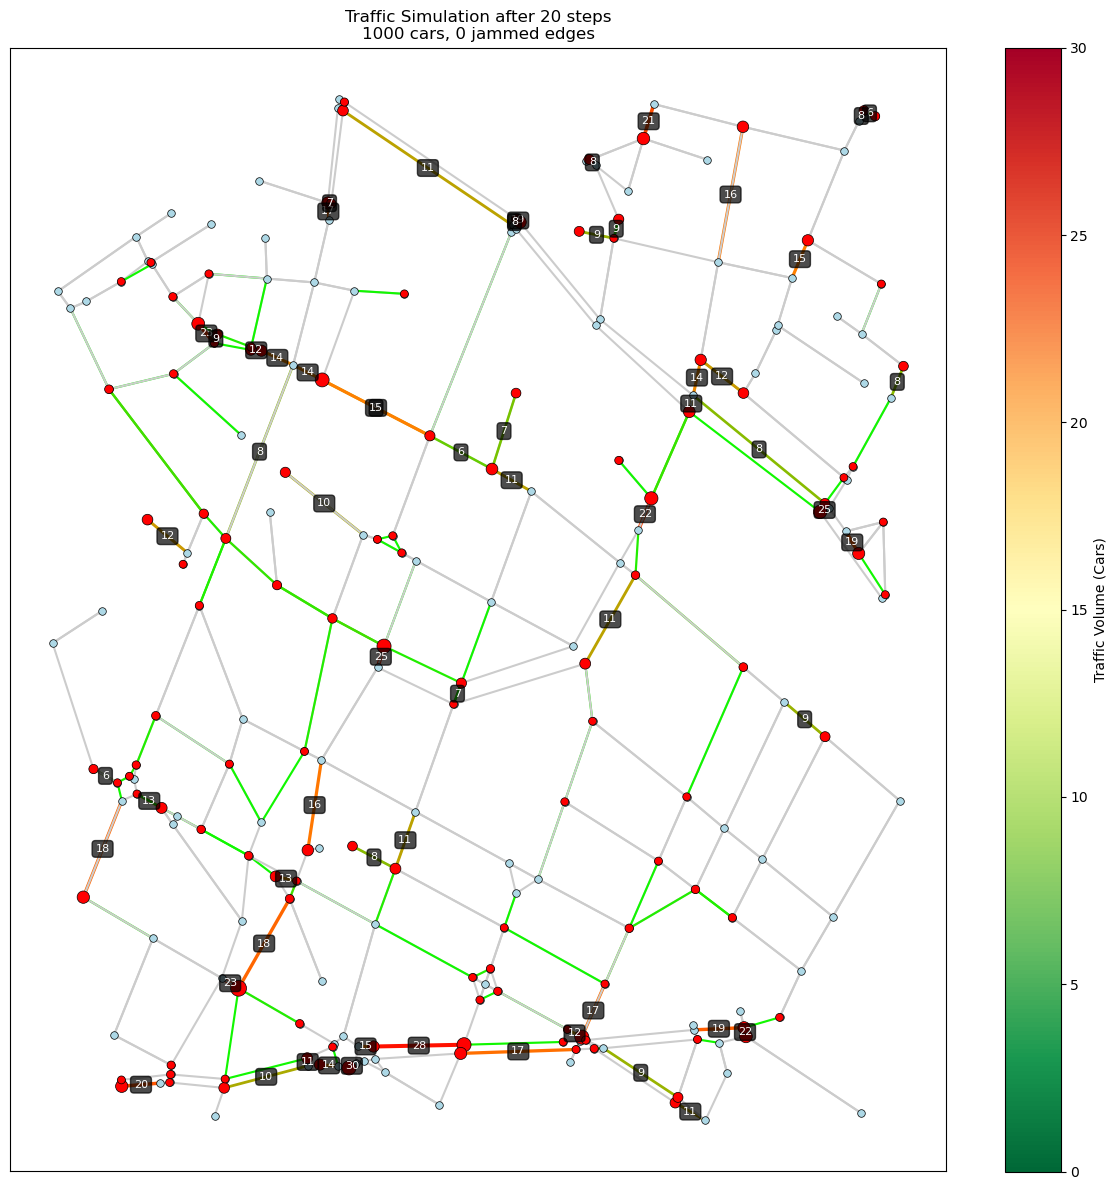

In [106]:
# Visualize the traffic after simulation
simulator.plot_traffic(figsize=(12, 12))

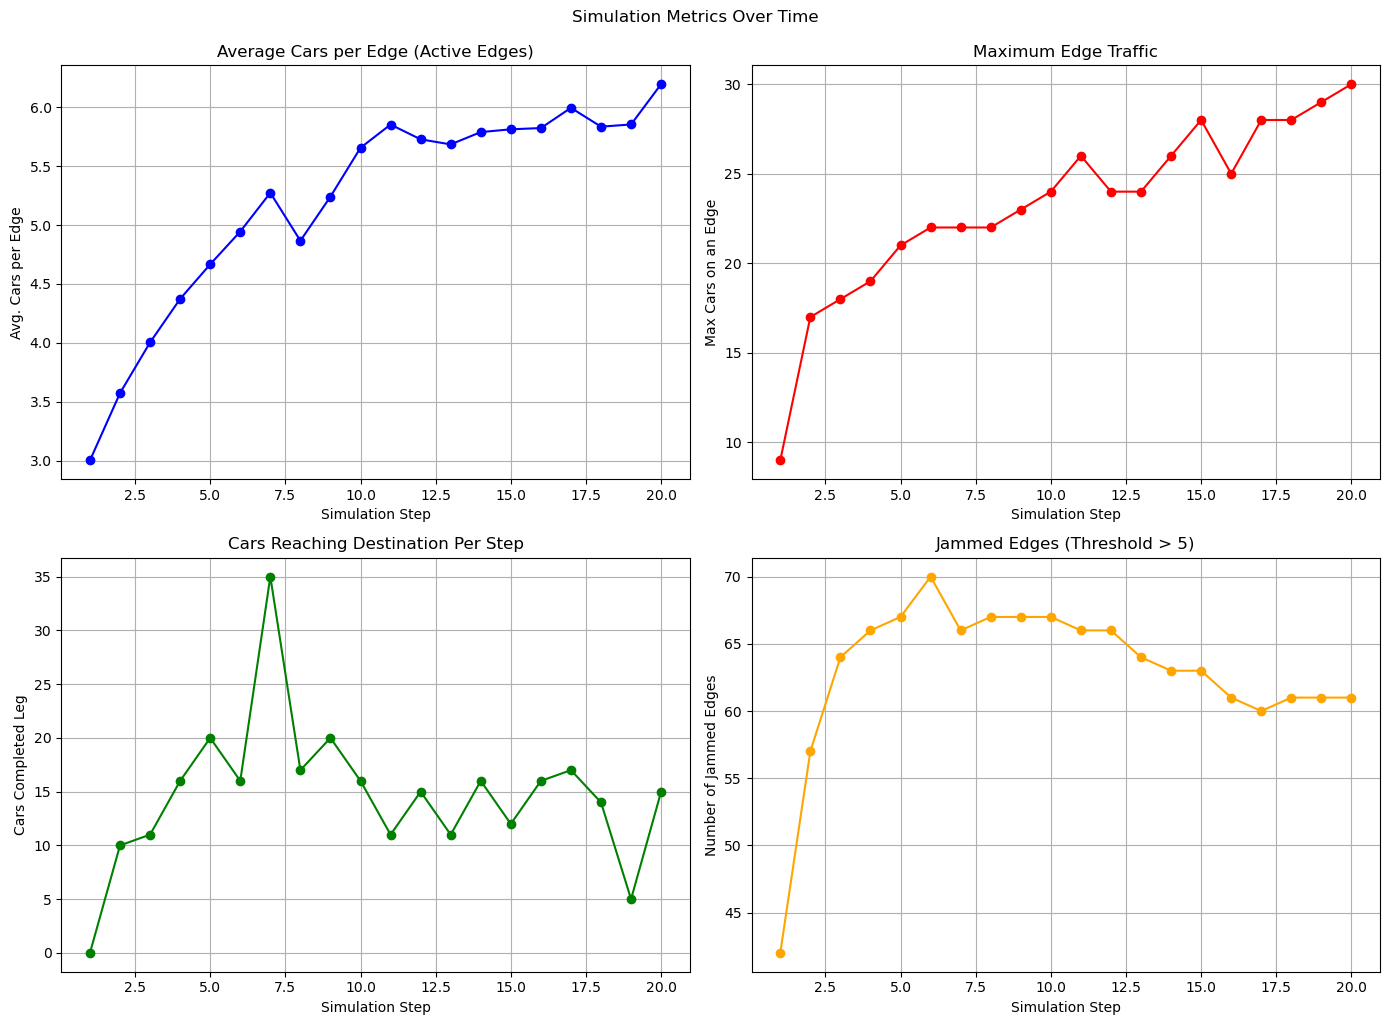

In [107]:
def plot_traffic_metrics(traffic_data, simulator):
    """Plot traffic metrics over time from simulation data.
    
    Args:
        traffic_data (list): List of dictionaries containing traffic data per step
        simulator (TrafficSimulator): The simulator instance (needed for jam threshold)
    """
    if not traffic_data:
        print("No traffic data available. Run the simulation first.")
        return
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    steps = [data['step'] for data in traffic_data]
    
    # Plot 1: Average edge traffic over time
    avg_traffic = [data['avg_edge_traffic'] for data in traffic_data]
    axs[0, 0].plot(steps, avg_traffic, 'b-', marker='o')
    axs[0, 0].set_title('Average Cars per Edge (Active Edges)')
    axs[0, 0].set_xlabel('Simulation Step')
    axs[0, 0].set_ylabel('Avg. Cars per Edge')
    axs[0, 0].grid(True)
    
    # Plot 2: Maximum edge traffic over time
    max_traffic = [data['max_edge_traffic'] for data in traffic_data]
    axs[0, 1].plot(steps, max_traffic, 'r-', marker='o')
    axs[0, 1].set_title('Maximum Edge Traffic')
    axs[0, 1].set_xlabel('Simulation Step')
    axs[0, 1].set_ylabel('Max Cars on an Edge')
    axs[0, 1].grid(True)
    
    # Plot 3: Cars reaching destination per step
    destinations = [data['reached_destination'] for data in traffic_data]
    axs[1, 0].plot(steps, destinations, 'g-', marker='o')
    axs[1, 0].set_title('Cars Reaching Destination Per Step')
    axs[1, 0].set_xlabel('Simulation Step')
    axs[1, 0].set_ylabel('Cars Completed Leg')
    axs[1, 0].grid(True)
    
    # Plot 4: Jammed edges over time
    jammed = [data.get('jammed_edges', 0) for data in traffic_data] # Use .get for backward compatibility
    axs[1, 1].plot(steps, jammed, 'orange', marker='o')
    axs[1, 1].set_title(f'Jammed Edges (Threshold > {simulator.traffic_jam_threshold})')
    axs[1, 1].set_xlabel('Simulation Step')
    axs[1, 1].set_ylabel('Number of Jammed Edges')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.suptitle("Simulation Metrics Over Time", y=1.02) # Add overall title
    plt.show()

# Update the call to pass the simulator instance
# Plot the traffic metrics from our simulation
plot_traffic_metrics(traffic_data, simulator)

In [108]:
# --- New Plotting Functions ---

def plot_travel_time_histogram(simulator):
    """Plots a histogram of the final travel times for all cars."""
    travel_times = [car.travel_time for car in simulator.cars if car.travel_time > 0]
    if not travel_times:
        print("No cars completed journeys with travel time > 0 to plot histogram.")
        return
        
    plt.figure(figsize=(10, 6))
    plt.hist(travel_times, bins=20, color='purple', edgecolor='black')
    plt.title('Distribution of Final Car Travel Times')
    plt.xlabel('Travel Time (minutes)')
    plt.ylabel('Number of Cars')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

def plot_reroute_histogram(simulator):
    """Plots a histogram of the final reroute counts for all cars."""
    reroute_counts = [car.reroute_count for car in simulator.cars]
    # Include cars with 0 reroutes if there are any
    if not reroute_counts and not any(c.reroute_count > 0 for c in simulator.cars):
         print("No rerouting occurred.")
         return
        
    plt.figure(figsize=(10, 6))
    # Determine appropriate bins, maybe up to max reroutes + 1
    max_reroutes = max(reroute_counts) if reroute_counts else 0
    bins = range(int(max_reroutes) + 2)
    plt.hist(reroute_counts, bins=bins, color='cyan', edgecolor='black', align='left')
    plt.title('Distribution of Car Reroute Counts')
    plt.xlabel('Number of Reroutes')
    plt.ylabel('Number of Cars')
    plt.xticks(bins[:-1])
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# --- End New Plotting Functions ---

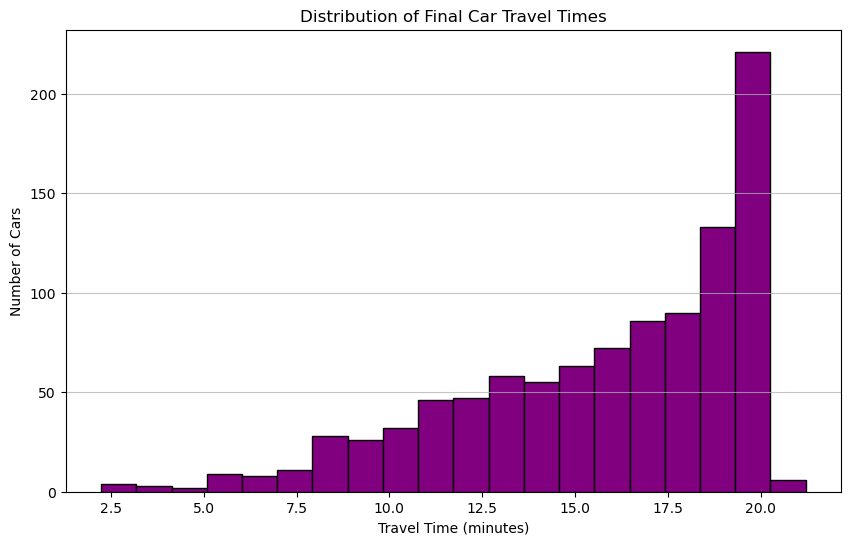

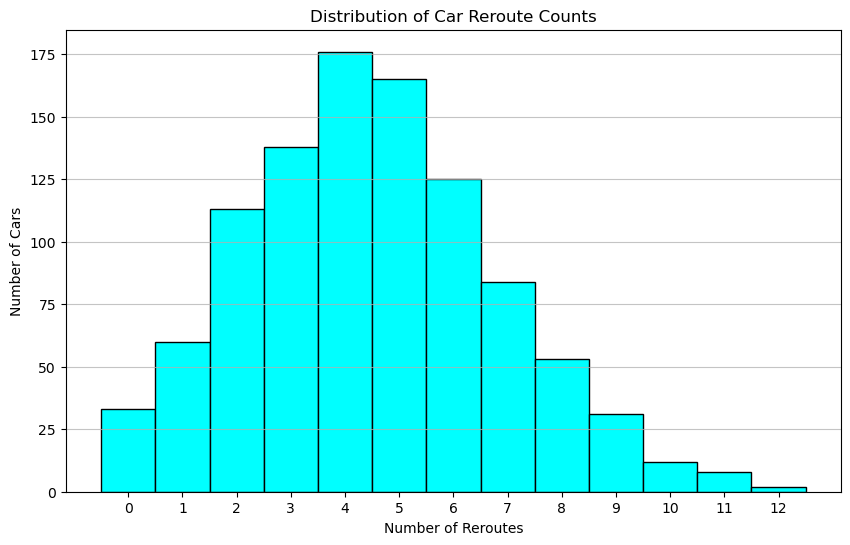

In [109]:
# Call the new plotting functions
plot_travel_time_histogram(simulator)
plot_reroute_histogram(simulator)

In [ ]:
# Diagnostic analysis to understand why cars aren't moving
def diagnose_simulation(simulator):
    """Analyzes the simulation to identify why cars aren't moving."""
    path_issues = 0
    valid_paths = 0
    path_lengths = []
    same_nodes = 0
    network_issues = 0
    
    # Verify network connectivity
    is_connected = nx.is_strongly_connected(simulator.G)
    connected_components = list(nx.strongly_connected_components(simulator.G))
    largest_component_size = len(max(connected_components, key=len))
    total_nodes = len(simulator.G.nodes)
    
    # Examine each car
    for i, car in enumerate(simulator.cars[:20]):  # Look at first 20 cars for sample
        print(f"Car {i}:")
        print(f"  Current location: {car.current_location}")
        print(f"  Destination: {car.destination}")
        print(f"  Path length: {len(car.path)}")
        print(f"  Path: {car.path[:5]}{'...' if len(car.path) > 5 else ''}")
        print(f"  Travel time: {car.travel_time}")
        print(f"  Reroute count: {car.reroute_count}")
        
        # Try to calculate a path
        try:
            path = nx.shortest_path(simulator.G, car.current_location, 
                                 car.destination, weight="travel_time")
            valid_paths += 1
            path_lengths.append(len(path))
            if len(path) == 1:
                same_nodes += 1
        except nx.NetworkXNoPath:
            network_issues += 1
            print(f"  ERROR: No path exists from {car.current_location} to {car.destination}")
        except Exception as e:
            path_issues += 1
            print(f"  ERROR: {str(e)}")
            
    # Report findings
    print(f"\nNetwork Analysis:")
    print(f"  Network is strongly connected: {is_connected}")
    print(f"  Number of strongly connected components: {len(connected_components)}")
    print(f"  Largest component size: {largest_component_size} of {total_nodes} nodes ({largest_component_size/total_nodes*100:.1f}%)")
    print(f"\nCar Paths Analysis:")
    print(f"  Cars with valid paths: {valid_paths} of 20")
    print(f"  Cars with path calculation errors: {path_issues}")
    print(f"  Cars with no network path: {network_issues}")
    print(f"  Cars with same start/end node: {same_nodes}")
    if path_lengths:
        print(f"  Average path length: {sum(path_lengths)/len(path_lengths):.1f} nodes")
        print(f"  Min path length: {min(path_lengths)} nodes")
        print(f"  Max path length: {max(path_lengths)} nodes")
    else:
        print("  No valid paths found to analyze lengths")

    # Check travel time edge attribute
    print("\nEdge 'travel_time' Attribute Check:")
    edges_with_time = sum(1 for _, _, data in simulator.G.edges(data=True) 
                        if 'travel_time' in data and data['travel_time'] > 0)
    total_edges = simulator.G.number_of_edges()
    print(f"  Edges with valid travel_time > 0: {edges_with_time} of {total_edges} ({edges_with_time/total_edges*100:.1f}%)")
    
    # Sample some edge travel times
    print("\nSample Edge travel_time values:")
    for i, (u, v, data) in enumerate(list(simulator.G.edges(data=True))[:10]):
        print(f"  Edge {i}: ({u}, {v}) travel_time = {data.get('travel_time', 'Missing')}")
        
# Run diagnostics
diagnose_simulation(simulator)

Car 0:
  Current location: 29276764
  Destination: 10593327815
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 1:
  Current location: 29215073
  Destination: 29217317
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 2:
  Current location: 29276730
  Destination: 29216575
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 3:
  Current location: 29273069
  Destination: 29217325
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 4:
  Current location: 268466879
  Destination: 1285251472
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 5:
  Current location: 26960761
  Destination: 5984003369
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 6:
  Current location: 29217348
  Destination: 3463840860
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count: 0
Car 7:
  Current location: 2891066381
  Destination: 29215049
  Path length: 0
  Path: []
  Travel time: 0
  Reroute count

## Fixing the Simulation

Based on the diagnostics, we'll update the TrafficSimulator class to fix the movement issues and adjust the traffic jam threshold to a more appropriate value.